In [39]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [56]:
# Set visual style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

#### Load the dataset inspect number of rows

In [40]:
# Load data
df = pd.read_csv('../data/processed/silver_sales.csv', parse_dates=['invoice_date'], dtype={
    'quantity': np.int32,
    'year': 'category',
    'month': 'category',
    'invoice': 'object',
    'customer_id': 'object'
})

df.shape

(1026426, 11)

The dataset has 1,026,426 rows with 11 columns.

#### Dataset Overview and Cleaning Check

In [41]:
print("Dataset Info:")
df.info()

# Display first few rows
print("\nFirst five rows:")
print(df.head())

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Check descriptive statistics for numerical columns
df.describe()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1026426 entries, 0 to 1026425
Data columns (total 11 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   invoice       1026426 non-null  object        
 1   stockcode     1026426 non-null  object        
 2   description   1026426 non-null  object        
 3   quantity      1026426 non-null  int32         
 4   invoice_date  1026426 non-null  datetime64[ns]
 5   year          1026426 non-null  category      
 6   month         1026426 non-null  category      
 7   price         1026426 non-null  float64       
 8   total_sale    1026426 non-null  float64       
 9   customer_id   794389 non-null   object        
 10  country       1026426 non-null  object        
dtypes: category(2), datetime64[ns](1), float64(2), int32(1), object(5)
memory usage: 68.5+ MB

First five rows:
  invoice stockcode                       description  quantity invoice_date  \
0  5

,quantity,invoice_date,price,total_sale
count,1.026426e+06,1026426,1.026426e+06,1.026426e+06
mean,1.089451e+01,2011-01-04 17:07:46.269560832,4.101661e+00,2.008085e+01
min,1.000000e+00,2009-12-01 00:00:00,1.000000e-03,0.000000e+00
25%,1.000000e+00,2010-07-14 00:00:00,1.250000e+00,3.900000e+00
50%,3.000000e+00,2010-12-08 00:00:00,2.100000e+00,1.000000e+01
75%,1.000000e+01,2011-07-25 00:00:00,4.150000e+00,1.770000e+01
max,7.421500e+04,2011-12-09 00:00:00,2.511109e+04,7.718360e+04
std,9.921495e+01,NaN,5.182760e+01,1.191381e+02


In [42]:
# Create a month_name column
month_map = {
    '1': 'January',
    '2': 'February',
    '3': 'March',
    '4': 'April',
    '5': 'May',
    '6': 'June',
    '7': 'July',
    '8': 'August',
    '9': 'September',
    '10': "October",
    '11': 'November',
    "12": "December"
}

df['month_name'] = df['month'].map(month_map)
df.drop(columns=['month'], inplace=True)
df.rename(columns={'month_name': 'month'}, inplace=True)
df['month'].astype('category')

invoice                 object
stockcode               object
description             object
quantity                 int32
invoice_date    datetime64[ns]
year                  category
price                  float64
total_sale             float64
customer_id             object
country                 object
month                 category
dtype: object

In [45]:
# Check for missing values
df.isnull().sum()

invoice              0
stockcode            0
description          0
quantity             0
invoice_date         0
year                 0
price                0
total_sale           0
customer_id     232037
country              0
month                0
dtype: int64

Column `customer_id` has a total of 232,037 missing values. This could be due to guest checkouts, or data entry error. To continue with the analysis, we will include all transactions when performing product, and sales centric analysis. For customer centric analysis such as Recency, Frequency, and Monetary(RFM), and lifetime value we will exclude the missing values since we cannot pin them to any particular customer.

## Exploratory Data Analysis

In [46]:
# Let us create a dataset for customer centric analysis
df_customer = df[df['customer_id'].notna()].copy()  # We will use this dataframe to perform RFM analysis.

### Key metrics calculation

In [55]:
total_revenue = df['total_sale'].sum()
total_customers = df['customer_id'].nunique()
total_products = df['stockcode'].nunique()
total_orders = df['invoice'].nunique()
avg_order_value = total_revenue / total_orders

print("----Overall business overview")
print(f"Total Revenue: ${total_revenue:,.2f}")
print(f"Total Customers: {total_customers}")
print(f"Total Products: {total_products}")
print(f"Total Orders: {total_orders}")
print(f"Average Order Value: ${avg_order_value:.2f}")

----Overall business overview
Total Revenue: $20,611,502.10
Total Customers: 5875
Total Products: 4829
Total Orders: 40029
Average Order Value: $514.91


### Time Series Analysis

#### See monthly trends

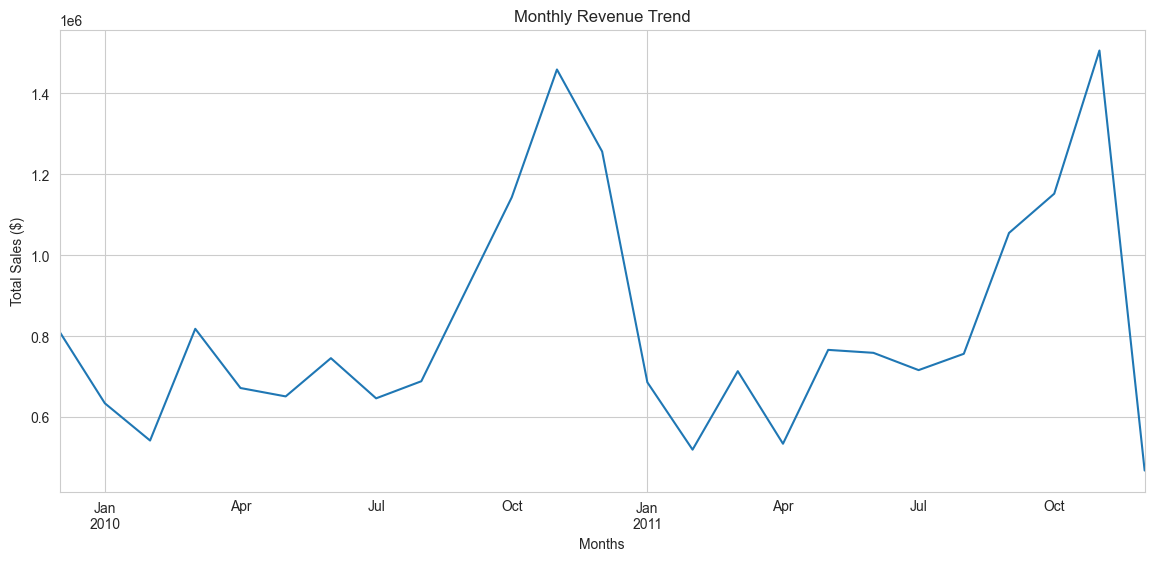

<Figure size 1200x600 with 0 Axes>

In [113]:
monthly_revenue = df.set_index('invoice_date')['total_sale'].resample('ME').sum()
plt.figure(figsize=(14, 6))
monthly_revenue.plot()
plt.title('Monthly Revenue Trend')
plt.ylabel('Total Sales ($)')
plt.xlabel('Months')
plt.show()
plt.savefig('../img/monthly_trend.png')

##### From our monthly sales graph, we can see that sales spike in `October` in both `2010` and `2011`. Also sales in `February` are usually low.

#### Yearly trends

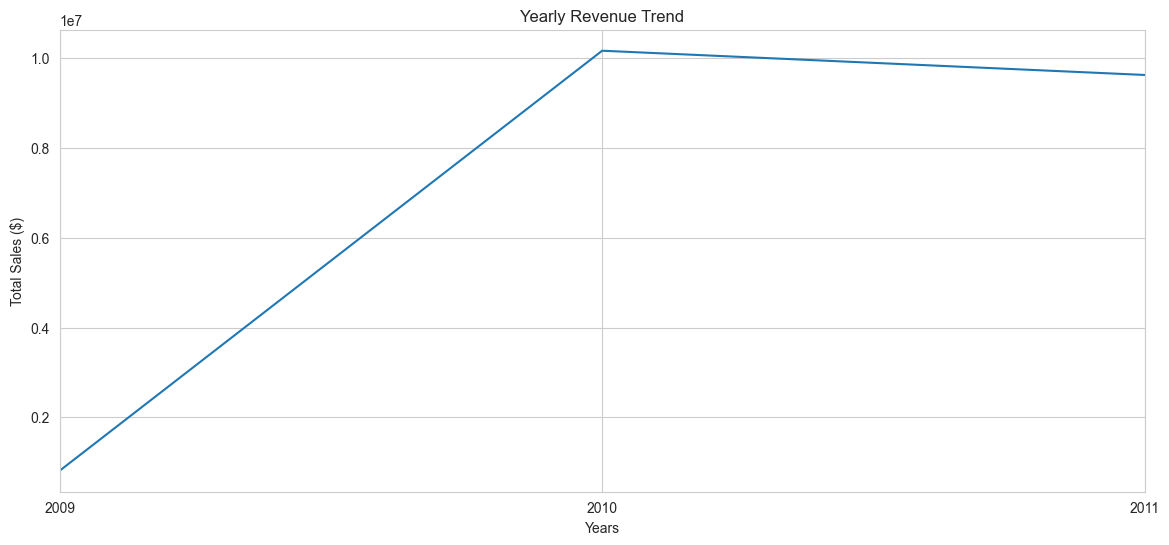

<Figure size 1200x600 with 0 Axes>

In [112]:
yearly_revenue = df.set_index('invoice_date')['total_sale'].resample('YE').sum()
plt.figure(figsize=(14, 6))
yearly_revenue.plot()
plt.title('Yearly Revenue Trend')
plt.ylabel('Total Sales ($)')
plt.xlabel('Years')
plt.show()
plt.savefig('../img/yearly_trend.png')

#### Number of Countries in operation per year

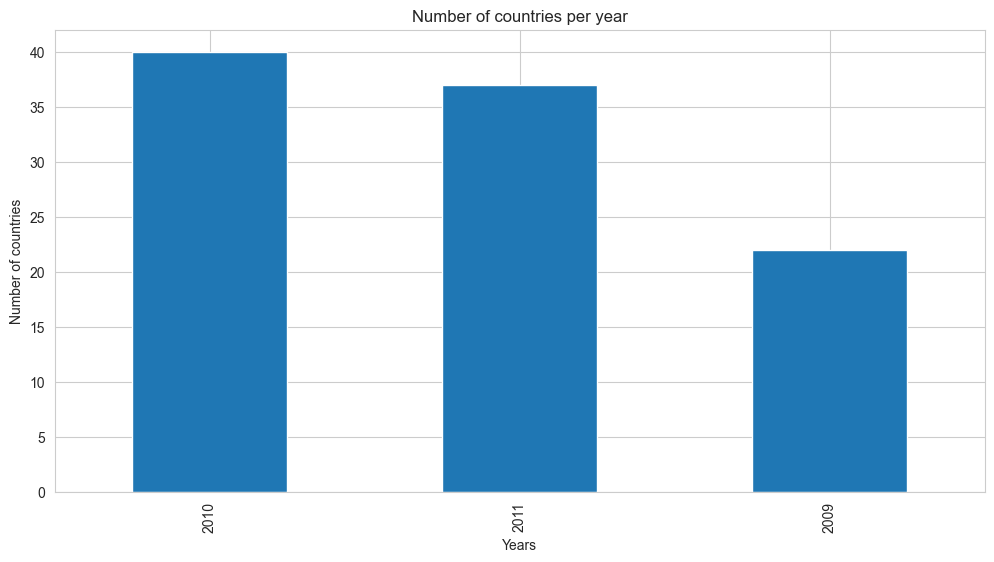

<Figure size 1200x600 with 0 Axes>

In [111]:
number_of_countries = df.groupby('year', observed=True)['country'].nunique()
number_of_countries.plot(kind='bar')
plt.xlabel('Years')
plt.ylabel('Number of countries')
plt.title('Number of countries per year')
plt.show()
plt.savefig('../img/countries_per_year.png')

##### We can see that total revenues was lowest in `2009` and highest in `2010`. All these can be attributed in number of countries the store operated in. In `2009`, the store operated in a total of 22 countries. In `2010`, this number increased to 40 and the slightly dropped to 37 in `2011`.

### Product Analysis
Here we check what are the top 10 products by revenue.

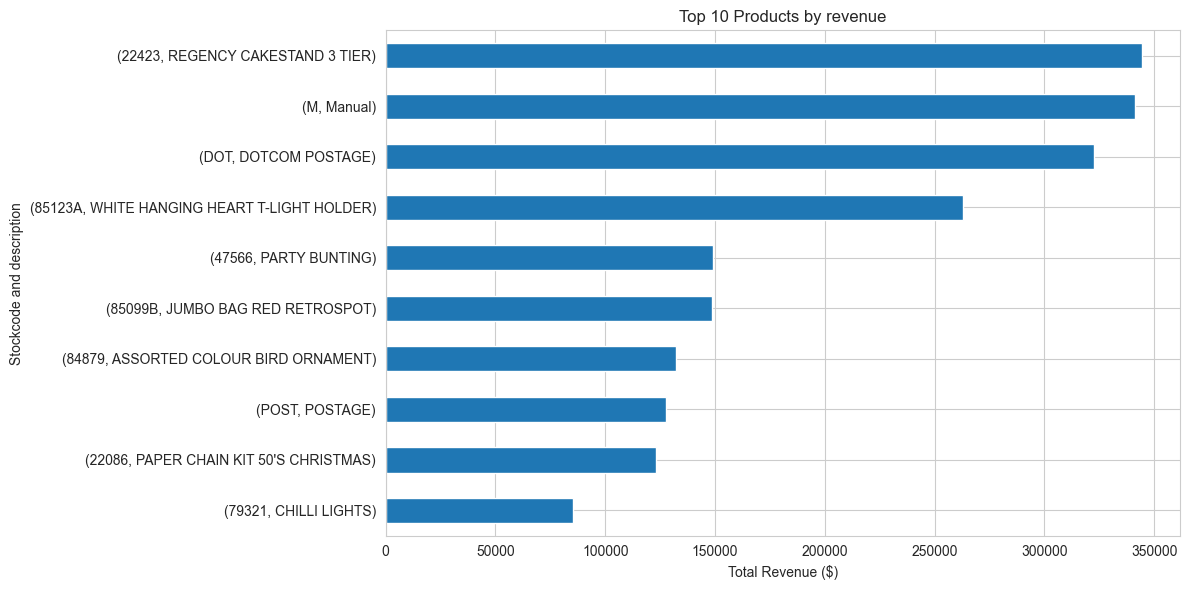

In [110]:
top_products = df.groupby(['stockcode', 'description'])['total_sale'].sum().nlargest(10)

plt.figure(figsize=(12, 6))
top_products.plot(kind='barh')
plt.title('Top 10 Products by revenue')
plt.xlabel('Total Revenue ($)')
plt.ylabel('Stockcode and description')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../img/product_sales.png')
plt.show()

### Customer analysis
In this section we will use the df_customer dataframe

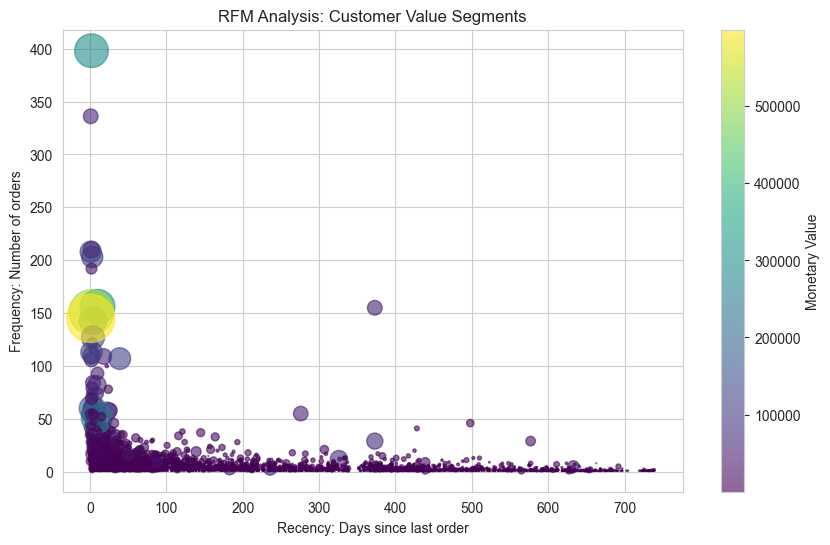

In [109]:
current_date = df_customer['invoice_date'].max() + pd.DateOffset(days=1)
rfm_table = df_customer.groupby('customer_id').agg({
    'invoice_date': lambda x: (current_date - x.max()).days, 
    'invoice': 'nunique',
    'total_sale': 'sum'
}).rename(columns={
    'invoice_date': 'recency',
    'invoice': 'frequency',
    'total_sale': 'monetary'  
})

plt.figure(figsize=(10, 6))
plt.scatter(rfm_table['recency'], rfm_table['frequency'], s=rfm_table['monetary'] * 0.002, c=rfm_table['monetary'], cmap='viridis', alpha=0.6)
plt.colorbar(label='Monetary Value')
plt.title('RFM Analysis: Customer Value Segments')
plt.xlabel('Recency: Days since last order')
plt.ylabel('Frequency: Number of orders')
plt.savefig('../img/rfm.png')
plt.show()

### Geographical analysis
Top 10 countries by revenue

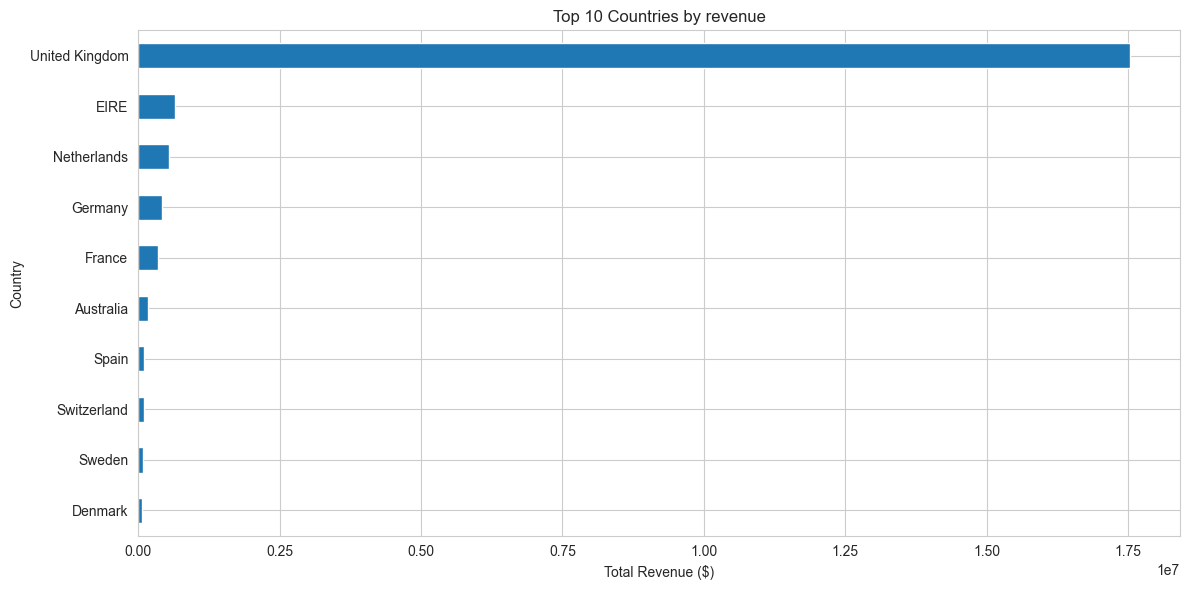

In [108]:
top_countries = df.groupby('country')['total_sale'].sum().nlargest(10)

plt.figure(figsize=(12, 6))
top_countries.plot(kind='barh')
plt.title('Top 10 Countries by revenue')
plt.xlabel('Total Revenue ($)')
plt.ylabel('Country')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../img/country_sales.png')
plt.show()

`United Kingdom` leads by far in revenue generation.